In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pyspark import SparkContext
from google.colab import drive
sc = SparkContext.getOrCreate()
drive.mount('/content/mydrive', force_remount=True)

Mounted at /content/mydrive


In [2]:
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'
def remove_quotes(s):
    return ''.join(i for i in s if i != '"')

In [3]:
def parse_data_file_line(data_file_line):
    match = re.search(DATAFILE_PATTERN, data_file_line)
    if match is None:
        print('Invalid datafile line: %s' % data_file_line)
        return (data_file_line, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: %s' % data_file_line)
        return (data_file_line, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((remove_quotes(match.group(1)), product), 1)

In [4]:
files = {
  'Amazon':                 "/content/mydrive/My Drive/CSCI-573/Amazon.csv"
, 'Google':                 "/content/mydrive/My Drive/CSCI-573/Google.csv"
, 'Amazon_small':           "/content/mydrive/My Drive/CSCI-573/Amazon_small.csv"
, 'Google_small':           "/content/mydrive/My Drive/CSCI-573/Google_small.csv"
, 'gold_standard':          "/content/mydrive/My Drive/CSCI-573/Amazon_Google_perfectMapping.csv"
, 'stopwords':              "/content/mydrive/My Drive/CSCI-573/stopwords.txt"
}

In [5]:
def parse_data(filename):
    return sc.textFile(filename, 4, use_unicode=True).map(parse_data_file_line)

In [6]:
def load_data(filekey):
    raw = parse_data(files[filekey]).cache()
    failed = raw.filter(lambda s: s[1] == -1).map(lambda s: s[0])
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (files[filekey], line))
    valid = raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
    print('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines'
        % (files[filekey], raw.count(), valid.count(), failed.count()))
    assert(failed.count() == 0)
    assert(raw.count() == (valid.count() + 1))
    return valid

In [7]:
google_small  = load_data('Google_small')
google        = load_data('Google')
amazon_small  = load_data('Amazon_small')
amazon        = load_data('Amazon')

/content/mydrive/My Drive/CSCI-573/Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
/content/mydrive/My Drive/CSCI-573/Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
/content/mydrive/My Drive/CSCI-573/Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
/content/mydrive/My Drive/CSCI-573/Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


In [8]:
for line in google_small.take(3):
    print('google: %s: %s\n' % (line[0], line[1]))
for line in amazon_small.take(3):
    print('amazon: %s: %s\n' % (line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup 

In [9]:
# (1a) Tokenize a string
quick_brown_fox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simple_tokenize(string):
    return [w for w in re.split(split_regex, string.lower()) if w != '']

print(simple_tokenize(quick_brown_fox))
#['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
print(simple_tokenize(' '))
#[]
print(simple_tokenize('!!!!123A/456_B/789C.123A'))
#['123a', '456_b', '789c', '123a']
print(simple_tokenize('fox fox'))
#['fox', 'fox']

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
[]
['123a', '456_b', '789c', '123a']
['fox', 'fox']


In [10]:
# (1b) Removing stopwords
stopfile = files['stopwords']
print(stopfile)
stopwords = set(sc.textFile(stopfile, 1, use_unicode=True).collect())
print('These are the stopwords:')
pprint(stopwords)

def tokenize(string):
    return [w for w in re.split(split_regex, string.lower())
               if w != '' and w not in stopwords]

print(tokenize(quick_brown_fox))
#['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']
print(tokenize("Why a the?"))
#[]
print(tokenize("Being at the_?"))
#['the_']

/content/mydrive/My Drive/CSCI-573/stopwords.txt
These are the stopwords:
{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'did',
 'do',
 'does',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'itself',
 'just',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'now',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 's',
 'same',
 'she',
 'should',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 '

In [11]:
# (1c) Tokenizing the Small Datasets
# How many tokens, total, are there in the two datasets?
amazon_rec_to_token = amazon_small.map(lambda line: (line[0], tokenize(line[1])))
google_rec_to_token = google_small.map(lambda line: (line[0], tokenize(line[1])))

def count_tokens(RDD_vendor):
    return RDD_vendor.flatMap(lambda item: item[1]).count()

totalTokens = count_tokens(amazon_rec_to_token) + count_tokens(google_rec_to_token)
print('There are %s tokens in the combined datasets' % totalTokens)
#There are 22520 tokens in the combined datasets

There are 22520 tokens in the combined datasets


In [12]:
# (1d) Amazon Record with the Most Tokens
# Which Amazon record has the biggest number of tokens?
def find_biggest_record(RDD_vendor):
    return RDD_vendor.sortBy(lambda x: -len(x[1])).take(1)

biggest_record_amazon = find_biggest_record(amazon_rec_to_token)
print('The Amazon record with ID "%s" has the most tokens (%s)'
     % (biggest_record_amazon[0][0], len(biggest_record_amazon[0][1])))
#The Amazon record with ID "b000o24l3q" has the most tokens (1547)

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


In [13]:
# (2a) ) Implement a TF Function
def tf(tokens):
    TF = dict()
    for token in tokens:
        if token not in TF:
            TF[token] = 1
        else: TF[token] += 1
    for token in TF:
        TF[token] = TF[token] / len(tokens)
    return TF

pprint(tf(tokenize(quick_brown_fox)))
#{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox':
#0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}
pprint(tf(tokenize('one_ one_ two!')))
#{'two': 0.3333333333333333, 'one_': 0.6666666666666666}

{'brown': 0.16666666666666666,
 'dog': 0.16666666666666666,
 'fox': 0.16666666666666666,
 'jumps': 0.16666666666666666,
 'lazy': 0.16666666666666666,
 'quick': 0.16666666666666666}
{'one_': 0.6666666666666666, 'two': 0.3333333333333333}


In [14]:
# (2b) Create a Corpus
RDD_corpus = amazon_rec_to_token.union(google_rec_to_token)
print(RDD_corpus.count())
#400

400


In [15]:
# (2c) Implement an IDFs Function
# How many unique tokens are there?
def idfs(corpus):
    N = corpus.count()
    unique_tokens = corpus.map(lambda x: {t for t in x[1]})
    token_count_pair_tuple = unique_tokens.flatMap(lambda s: [(t, 1) for t in s])
    token_sum_pair_tuple = token_count_pair_tuple.reduceByKey(lambda total, count: total + count);
    return token_sum_pair_tuple.map(lambda x: (x[0], N / x[1]))

idfs_small = idfs(amazon_rec_to_token.union(google_rec_to_token))
unique_token_count = idfs_small.count()
print('There are %s unique tokens in the small datasets.' % unique_token_count)
#There are 4772 unique tokens in the small datasets.
token_smallest_idf = idfs_small.takeOrdered(1, lambda s: s[1])[0]
print(token_smallest_idf[0])
#software
print(abs(token_smallest_idf[1] - 4.25531914894) < 0.0000000001)
#True

There are 4772 unique tokens in the small datasets.
software
True


In [16]:
# (2d) Tokens with the Smallest IDF
small_IDF_tokens = idfs_small.takeOrdered(11, lambda s: s[1])
pprint(small_IDF_tokens)
#[('software', 4.25531914893617), ('new', 6.896551724137931), ('features', 6.896551724137931), ('use',
#7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('create',
#8.333333333333334), ('system', 8.333333333333334), ('cd', 8.333333333333334), ('1', 8.51063829787234),
#('windows', 8.51063829787234)]

[('software', 4.25531914893617),
 ('features', 6.896551724137931),
 ('new', 6.896551724137931),
 ('use', 7.017543859649122),
 ('complete', 7.2727272727272725),
 ('easy', 7.6923076923076925),
 ('create', 8.333333333333334),
 ('system', 8.333333333333334),
 ('cd', 8.333333333333334),
 ('1', 8.51063829787234),
 ('windows', 8.51063829787234)]


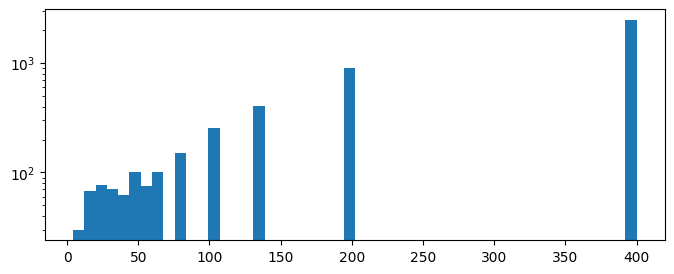

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


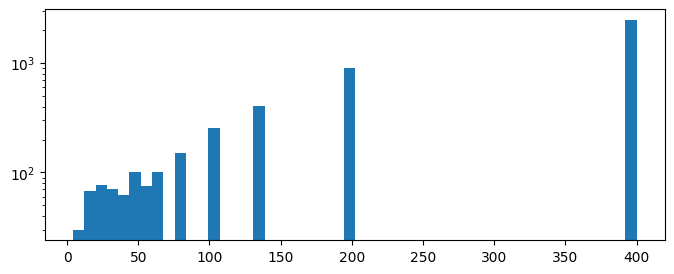

In [17]:
# (2e) IDF Histogram
import matplotlib.pyplot as plt
small_idf_values = idfs_small.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
display(fig)
pass
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
# Create a DataFrame and visualize using display()
idfs_to_count_row = idfs_small.map(lambda item: Row(token=item[0], value=item[1]))
idfs_to_count_DF = sqlContext.createDataFrame(idfs_to_count_row)
#display(idfs_to_count_DF)

In [18]:
# (2f) Implement a TF-IDF Function
def tfidf(tokens, idfs):
    tfs = tf(tokens)
    tf_idf_dict = {t: TF * idfs[t] for t, TF in tfs.items()}
    return tf_idf_dict

recb000hkgj8k = amazon_rec_to_token.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfs_small_weights = idfs_small.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfs_small_weights)
print('Amazon record "b000hkgj8k" has tokens and weights:')
pprint(rec_b000hkgj8k_weights)
#Amazon record "b000hkgj8k" has tokens and weights:
#{'autocad': 33.33333333333333, 'autodesk': 8.333333333333332, 'courseware': 66.66666666666666, 'psg':
#33.33333333333333, '2007': 3.5087719298245617, 'customizing': 16.666666666666664, 'interface':
#3.0303030303030303}

Amazon record "b000hkgj8k" has tokens and weights:
{'2007': 3.5087719298245617,
 'autocad': 33.33333333333333,
 'autodesk': 8.333333333333332,
 'courseware': 66.66666666666666,
 'customizing': 16.666666666666664,
 'interface': 3.0303030303030303,
 'psg': 33.33333333333333}


In [19]:
import math

def dotprod(a, b):
    sum = 0.0
    for t, at in a.items():
        if t in b:
            sum += at * b[t]
    return sum

def norm(a):
    sum = 0.0
    for t, at in a.items():
        sum += at * at
    return math.sqrt(sum)

def cossim(a, b):
    return dotprod(a, b) / (norm(a) * norm(b))

In [20]:
testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print(dp, nm)
#102 6.16441400297

102.0 6.164414002968976


In [21]:
# (3b) Implement a cosine_similarity Function
def cosine_similarity(string1, string2, idfs_dictionary):
    w1 = tfidf(tokenize(string1), idfs_small_weights)
    w2 = tfidf(tokenize(string2), idfs_small_weights)
    return cossim(w1, w2)

cossim_Adobe = cosine_similarity('Adobe Photoshop',  'Adobe Illustrator',  idfs_small_weights)
print(cossim_Adobe)
#0.0577243382163

0.05772433821630337


In [22]:
# (3c) Perform Entity Resolution
def compute_similarity(record):
    google_rec = record[0]
    amazon_rec = record[1]
    google_URL = google_rec[0]
    amazon_ID = amazon_rec[0]
    google_value = google_rec[1]
    amazon_value = amazon_rec[1]
    cs = cosine_similarity(google_value, amazon_value, idfs_small_weights)
    return (google_URL, amazon_ID, cs)

cross_small = google_small.cartesian(amazon_small).cache()
similarities = cross_small.map(lambda item: compute_similarity(item)).cache()

def similar(amazon_ID, google_URL):
    return (similarities
           .filter(lambda record: (record[0] == google_URL and record[1] == amazon_ID))
           .collect()[0][2])

similarity_amazon_google = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarity_amazon_google)
#Requested similarity is 0.000303171940451.

Requested similarity is 0.00030317194045132.


In [23]:
# (3d) Perform Entity Resolution with Broadcast Variables
def compute_similarity_broadcast(record):
    google_rec = record[0]
    amazon_rec = record[1]
    google_URL = google_rec[0]
    amazon_ID = amazon_rec[0]
    google_value = google_rec[1]
    amazon_value = amazon_rec[1]
    cs = cosine_similarity(google_value, amazon_value, idfs_small_broadcast.value)
    return (google_URL, amazon_ID, cs)

idfs_small_broadcast = sc.broadcast(idfs_small_weights)
similarities_broadcast = cross_small.map(lambda item: compute_similarity(item)).cache()

def similar_broadcast(amazonID, googleURL):
    return (similarities_broadcast
           .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
           .collect()[0][2])

similarity_amazon_google_broadcast = similar_broadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarity_amazon_google_broadcast)
#Requested similarity is 0.000303171940451.
print(len(idfs_small_broadcast.value))
#4772

Requested similarity is 0.00030317194045132.
4772


In [24]:
# (3e) Perform a Gold Standard Evaluation
# How many true duplicate pairs are there in the small datasets?
# What is the average similarity score for true duplicates?
# What about for non-duplicates?
GOLDFILE_PATTERN = '^(.+),(.+)'
def parse_goldfile_line(goldfile_line):
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: %s' % goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: %s' % goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (remove_quotes(match.group(1)), remove_quotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = files['gold_standard']
gs_raw = sc.textFile(goldfile).map(parse_goldfile_line).cache()
gs_failed = gs_raw.filter(lambda s: s[1] == -1).map(lambda s: s[0])
for line in gs_failed.take(10):
    print('Invalid goldfile line: %s' % line)
gold_standard = gs_raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
print('Read %d lines, successfully parsed %d lines, failed to parse %d lines'
     % (gs_raw.count(), gold_standard.count(),  gs_failed.count()))
assert (gs_failed.count() == 0)
assert (gs_raw.count() == (gold_standard.count() + 1))
#Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


In [25]:
sims = similarities_broadcast.map(lambda item: (item[1] + " " + item[0], item[2]))
RDD_true_dups = sims.join(gold_standard).map(lambda item: (item[0], item[1][0]))
true_dups_count = RDD_true_dups.count()
avg_sim_dups = RDD_true_dups.map(lambda item: item[1]) \
                            .reduce(lambda total, count: total + count) / true_dups_count
RDD_non_dups = sims.leftOuterJoin(gold_standard) \
                   .filter(lambda item: item[1][1] is None) \
                   .map(lambda item: (item[0], item[1][0]))
non_dups_count = RDD_non_dups.count()
avg_sim_non = RDD_non_dups.map(lambda item: item[1]) \
                          .reduce(lambda total, count: total + count) / non_dups_count
print('There are %s true duplicates.' % true_dups_count)
print('There are %s non duplicates.' % non_dups_count)
#There are 146 true duplicates.
print('The average similarity of true duplicates is %s.' % avg_sim_dups)
#The average similarity of true duplicates is 0.264332573435.
print('And for non duplicates, it is %s.' % avg_sim_non)
#And for non duplicates, it is 0.00123476304656.

There are 146 true duplicates.
There are 39854 non duplicates.
The average similarity of true duplicates is 0.26433257343519145.
And for non duplicates, it is 0.0012347630465555245.
